In [0]:
#@title
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Séries Temporais (Parte 3) - Testes Estatísticos e ARIMA

Notebook de apoio para a **Aula 003: Séries Temporais - Testes Estatísticos e ARIMA**

## Introdução às Séries Estacionárias

Como vimos no final da aula passada, um pré-requisito para que possamos fazer previsões em cima de uma TS é ela ser estacionária.

De maneira simplificada, ser estacionária significa ter a média, variância e covariância permanecendo constante ao longo da dimensão temporal. Vamos entender visualmente o que isso significa.

<center>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns5-e1536673990684.png" width="50%"></center>

No primeiro plot, há uma tendência de alta. Ou seja, a sua média está aumentando conforme o tempo passa. No segundo plot, apesar de não haver uma variação na tendência, a variância (não constante) está interferindo na sua amplitude. Por fim, o último exibe o comportamento típico de quando a covariância varia em função do tempo.

**E como se pareceria uma série estacionária?**

Uma TS com média, variância e covariância constante seria parecida com o plot abaixo.

<center><img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/ns6-e1536674898419.png" width="20%"></center>

**Como verificar se uma TS é estacionária?**

Há muitas maneiras se fazer essa verificação. Por exemplo:

* **Olhar os plots -** Em muitos casos, durante a análise exploratória você já vai identificar visualmente se uma TS é estacionária ou não.
* **Resumo estatístico -** Você pode gerar um resumo com as principais informações estatísticas da TS, e verificar se há algum indício da estacionaridade.
* **Testes estatísticos -** São testes que possuem a capacidade de nos dizer se uma TS é estacionária ou não, sempre se baseando em métodos científicos.

Nesta aula, focaremos em um teste estatístico específico para identificar se nossa TS é estacionária ou não, o teste ***Augmented Dickey Fuller (ADF)***

### Teste ADF

Como falamos anteriormente, o ADF é um dos testes estatísticos mais usados para TS. Suas hipóteses nula e alternativa são:

* A Hipótese Nula ($H_0$) do teste é que a TS não é estacionária. Ou seja, possui algum tipo de dependência em relação ao tempo.
* A Hipótese Alternativa ($H_1$) rejeita a hipótese nula, ou seja, que a TS é estacionária.

Vamos realizar o ADF em cima do *dataset* do consumo de energia elétrica.


In [0]:
# importar pacotes e setar configurações de plots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller # importar o teste ADF

sns.set_style()

%config InlineBackend.figure_format = 'svg'

In [3]:
# url do dataset
dataset_path = "https://raw.githubusercontent.com/carlosfab/escola-data-science/master/datasets/electricity_consumption/Electric_Production.csv"

# importar o csv para um dataframe
df = pd.read_csv(dataset_path)
df.DATE = pd.to_datetime(df.DATE, format="%m-%d-%Y")
df.set_index('DATE', inplace=True)

# extrair apenas os valores
X = df.Value.values

# aplicar ADF e imprimir o resultado
result = adfuller(X)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result[0]))
print('Valor-p: {:.4f}'.format(result[1]))
print('Valores Críticos:')
for key, value in result[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -2.2570
Valor-p: 0.1862
Valores Críticos:
	1%: -3.4476
	5%: -2.8692
	10%: -2.5708


Normalmente, rejeitamos $H_0$ quando o *p-value* é menor ou igual a um determinado nível de significância. Normalmente, esse nível de significância é igual a 0.01 (5%), 0.05 (5%) ou até mesmo 0.1 (10%).

Quanto menor o *p-value*, mais evidências contra a hipótese nula você tem. Por exemplo, caso seja usado $\text{p-value} = 0.05$, rejeitamos a $H_0$ com um nível de confiança de 95%. 

Caso o valor do teste fique acima do *threshold*, falharemos em rejeitar a hipótese nula. **Atenção, isso não significa que $H_0$ é verdadeira.** Significa apenas que o experimento não encontrou evidências para rejeitá-la.

### Transformando uma TS em estacionária

Para transformar uma TS em estacionária, precisamos remover a tendência e a sazonalidade que há nos dados originais. Para isso, existem diversas técnicas que podem ser usadas.

Uma bom começo é aplicar o $log$ a fim de reduzirmos a magnitude dos valores da TS. Na sequência, subtraímos a média móvel de um determinado período em relação ao $log$ da TS.

In [4]:
# ver o plot original
ma = df.rolling(12).mean()

fig, ax = plt.subplots()
df.plot(ax=ax, legend=False)
ma.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

In [5]:
# aplicar log
df_log = np.log(df)
ma_log = df_log.rolling(12).mean()

fig, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, color='r', legend=False)
plt.tight_layout()

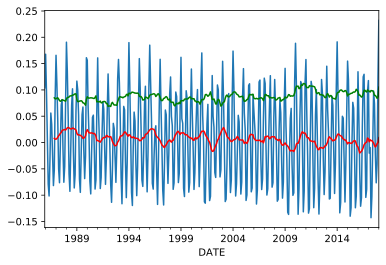

In [6]:
# subtrair a média do log dos dados
df_sub = (df_log - ma_log).dropna()
ma_sub = df_sub.rolling(12).mean()
std_sub = df_sub.rolling(12).std()

fig, ax = plt.subplots()
df_sub.plot(ax=ax, legend=False)
ma_sub.plot(ax=ax, color='r', legend=False)
std_sub.plot(ax=ax, color='g', legend=False)
plt.show()

In [7]:
# repetir o ADF
X_sub = df_sub.Value.values

# aplicar ADF e imprimir o resultado
result_sub = adfuller(X_sub)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_sub[0]))
print('Valor-p: {:.10f}'.format(result_sub[1]))
print('Valores Críticos:')
for key, value in result_sub[4].items():
	print('\t{}: {:.4f}'.format(key, value))

Dickey-Fuller Aumentado
Teste Estatístico: -5.2116
Valor-p: 0.0000083256
Valores Críticos:
	1%: -3.4481
	5%: -2.8694
	10%: -2.5709


Olhando os resultados tanto do teste estatísticom quanto o gráfico acima, podemos verificar que a tendência foi removida, tornando a série estacionária.

#### Diferenciação

Uma outra técnica simples que ajuda a tornar TS mais estacionárias é a diferenciação.

Apenas calculando a diferença entre duas observações possíveis, é possível incrementar ainda mais o desempenho no ADF.

$$value(t) = observation(t) - observation(t -1)$$

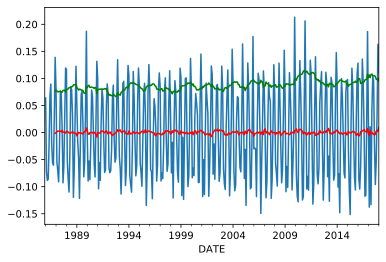

Dickey-Fuller Aumentado
Teste Estatístico: -7.6511
Valor-p: 0.0000000000
Valores Críticos:
	1%: -3.4483
	5%: -2.8694
	10%: -2.5710


In [8]:
# aplicar diferenciação
df_diff = df_sub.diff(1)
ma_diff = df_diff.rolling(12).mean()
std_diff = df_diff.rolling(12).std()

fig, ax = plt.subplots()
df_diff.plot(ax=ax, legend=False)
ma_diff.plot(ax=ax, color='r', legend=False)
std_diff.plot(ax=ax, color='g', legend=False)
plt.show()

# extrair apenas os valores
X_diff = df_diff.Value.dropna().values

# aplicar ADF e imprimir o resultado
result_diff = adfuller(X_diff)
print('Dickey-Fuller Aumentado')
print('Teste Estatístico: {:.4f}'.format(result_diff[0]))
print('Valor-p: {:.10f}'.format(result_diff[1]))
print('Valores Críticos:')
for key, value in result_diff[4].items():
	print('\t{}: {:.4f}'.format(key, value))

## *Forecasting* usando ARIMA

ARIMA significa *AutoRegressive Integrated Moving Average* e é um dos modelos mais usados para fazer previsões em cima de Séries Temporais.

É uma classe de modelo que consegue capturar um conjunto de diferentes estruturas temporais dados de TS. O acrônimo ARIMA significa:

* **AR**: *Autoregression*, pois usa a relação de dependência entre uma observação e um número de *lagged observations*.
* **I**: *Integrated*, pois usa a diferenciação das observações *raw* para transformar a TS em estacionária.
* **MA**: *Moving Average*, pois usa a dependência entre uma observação e o erro residual proveniente de uma média móvel aplicada a *lagged observations*.

Cada um desses componentes são representados por um parâmetro do modelo. Por esse fato, é muito comum ver a notação $ARIMA(p, d, q)$.

Para encontrar os parâmetros otimizados de p, d, e q, usaremos as funções ACF (Autocorrelação) e PACF (Autocorrelação Parcial).

In [9]:
# melhores parâmetros para o nosso modelo
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Além de plotar os gráficos para ACF e PACF, vamos plotar os limites críticos. Ou seja, 5% da autocorrelação (parcial) para TS estacionárias, $1.96 / \sqrt{(N - d)}$, onde $N$ é o número de pontos do *dataset* e $d$ é o número de vezes que diferenciamos os dados.

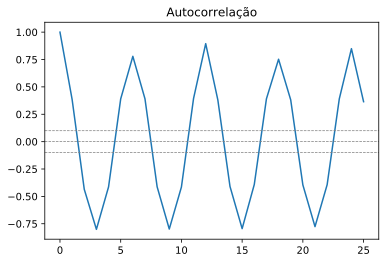

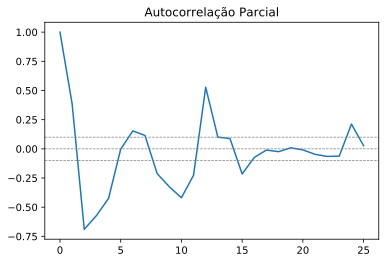

In [10]:
# plotar ACR e PACF
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=-1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação")
plt.show()

plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=-1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.axhline(y=1.96 / np.sqrt((len(df_diff) - 1)), linestyle='--', color='gray', linewidth=0.7)
plt.title("Autocorrelação Parcial")
plt.show()

Os valores otimizados dos parâmetros do ARIMA são identificados ao olharmos os plots acima:

* **q:** valor onde a ACF cruza o limite superior do intervalo de confiança pela primeira vez. 
* **p:** valor onde o PACF cruza o limite superor do intervalo de confiança pela primeira vez.

Vamos agora construir o modelo ARIMA.

In [11]:
# treinar o modelo ARIMA
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(2,1,2))
result_AR = model.fit(disp = -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


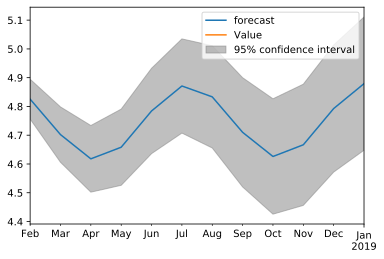

In [12]:
# start="2018-02-01", end="2019-01-01"
result_AR.plot_predict(start="2018-02-01", end="2019-01-01");